# **STANDARISASI DATA**

In [ ]:
from google.colab import files

# import file
uploaded = files.upload()

In [ ]:
# Import pustaka yang dibutuhkan
import pandas as pd

# Muat dataset
file_path = "Ling.csv"  # Ubah ke path file Anda jika berbeda
data = pd.read_csv(file_path)

# Lihat beberapa baris pertama data
print("Preview Data:")
print(data.head())

# Periksa informasi dataset
print("\nInfo Data:")
print(data.info())

# Periksa distribusi nilai yang hilang
print("\nJumlah nilai yang hilang per kolom:")
print(data.isnull().sum())


FileNotFoundError: [Errno 2] No such file or directory: 'Ling.csv'

In [ ]:
# Muat ulang dataset
data = pd.read_csv(file_path)

# Pastikan kolom 'subject' ada
if 'subject' in data.columns:
    # 1. Tangani nilai yang hilang di kolom 'subject'
    data['subject'] = data['subject'].fillna("no_subject")

    # 2. Gabungkan kolom 'subject' dan 'body' menjadi kolom 'text'
    data['text'] = data['subject'] + " " + data['body']

    # 3. Hapus kolom yang tidak lagi digunakan
    data = data.drop(columns=['subject', 'body'])

# 4. Ubah teks menjadi huruf kecil
data['text'] = data['text'].str.lower()

# 5. Hapus baris duplikat
data = data.drop_duplicates()

# Periksa hasil setelah preprocessing
print("Preview data setelah normalisasi:")
print(data.head())

print("\nJumlah data setelah preprocessing:", len(data))


In [ ]:
# Pastikan kolom 'text' dan 'label' ada
if {'text', 'label'}.issubset(data.columns):
    # 1. Membersihkan teks pada kolom 'text'
    data['text'] = (
        data['text']
        .str.replace(r'[^\x00-\x7F]+', ' ', regex=True)  # Hapus karakter non-ASCII
        .str.replace(r'\s+', ' ', regex=True)           # Hapus spasi berlebih
        .str.strip()                                    # Hapus spasi di awal/akhir teks
    )

    # 2. Standarisasi kolom 'label'
    data['label'] = data['label'].replace({1: 'penipuan', 0: 'bukan penipuan'})

    # 3. Hapus baris duplikat
    data_cleaned = data.drop_duplicates()

    # 4. Simpan dataset yang sudah dibersihkan
    data_cleaned.to_csv('cleaned_Ling.csv', index=False)

    # 5. Unduh dataset yang sudah dibersihkan
    from google.colab import files
    files.download('cleaned_Ling.csv')

    print("Dataset telah dibersihkan, distandarisasi, dan siap digunakan.")
else:
    print("Kolom 'text' atau 'label' tidak ditemukan. Periksa dataset Anda.")


# **STANDARISASI TF-IDF**

In [ ]:
from google.colab import files

# import file
uploaded = files.upload()


Saving cleaned_Ling.csv to cleaned_Ling.csv


In [ ]:
data = pd.read_csv('cleaned_Ling.csv')
print(data.head())

            label                                               text
0  bukan penipuan  job posting - apple-iss research center conten...
1  bukan penipuan  no_subject lang classification grimes , joseph...
2  bukan penipuan  query : letter frequencies for text identifica...
3  bukan penipuan  risk a colleague and i are researching the dif...
4  bukan penipuan  request book information earlier this morning ...


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import joblib

# Memuat dataset cleaned_Ling
data = pd.read_csv('cleaned_Ling.csv')

# Preprocessing teks
data['text'] = data['text'].str.replace(r'\b\d{5,}\b', '', regex=True)  # Hapus angka panjang
data['text'] = data['text'].str.replace(r'\b\w{1,2}\b', '', regex=True)  # Hapus kata pendek

# Pastikan dataset memiliki kolom 'text' dan 'label'
X = data['text']  # Fitur teks
y = data['label']  # Label

# Terapkan TF-IDF
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=20000,
    min_df=0.02,  # Kata harus muncul di setidaknya 2% dokumen
    token_pattern=r'\b[a-zA-Z]{3,}\b'  # Hanya kata dengan panjang minimal 3 huruf
)

X_tfidf = vectorizer.fit_transform(X)

# Scaling menggunakan MaxAbsScaler
scaler = MaxAbsScaler()
X_tfidf_scaled = scaler.fit_transform(X_tfidf)

# Split data menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_scaled, y, test_size=0.2, random_state=42)

# Terapkan SMOTE pada data train
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Periksa distribusi data setelah SMOTE
print("Distribusi label setelah SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Melatih model Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)

# Evaluasi model
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Gunakan kembali indeks asli dari train_test_split untuk data uji
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat DataFrame data uji menggunakan data asli
test_data = pd.DataFrame({'text': X_test_orig, 'label': y_test_orig})

# Pisahkan kelas minoritas dan mayoritas
penipuan = test_data[test_data['label'] == 'penipuan']
bukan_penipuan = test_data[test_data['label'] == 'bukan penipuan']

# Undersampling kelas mayoritas
from sklearn.utils import resample

bukan_penipuan_balanced = resample(
    bukan_penipuan,
    replace=False,
    n_samples=len(penipuan),
    random_state=42
)

# Gabungkan kembali data uji yang seimbang
balanced_test_data = pd.concat([penipuan, bukan_penipuan_balanced])

# Siapkan kembali TF-IDF pada data uji yang seimbang
X_test_balanced = vectorizer.transform(balanced_test_data['text'])
y_test_balanced = balanced_test_data['label']

# Prediksi dan evaluasi ulang
y_pred_balanced = nb_model.predict(X_test_balanced)
print("Evaluasi dengan Data Uji Seimbang:")
print(classification_report(y_test_balanced, y_pred_balanced))


# Menyimpan model dan vectorizer
joblib.dump(nb_model, 'naive_bayes_model.pkl')  # Simpan model Naive Bayes
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')  # Simpan vectorizer TF-IDF
joblib.dump(scaler, 'scaler.pkl')  # Simpan scaler

# Menampilkan top features dari setiap label
# Pisahkan data berdasarkan label untuk analisis fitur
fraud_texts = data[data['label'] == 'penipuan']['text']
non_fraud_texts = data[data['label'] == 'bukan penipuan']['text']

# TF-IDF untuk label 'penipuan'
fraud_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=20,  # Ambil top 20 fitur
    token_pattern=r'\b[a-zA-Z]{3,}\b'
)
fraud_tfidf = fraud_vectorizer.fit_transform(fraud_texts)

# TF-IDF untuk label 'bukan penipuan'
non_fraud_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=20,
    token_pattern=r'\b[a-zA-Z]{3,}\b'
)
non_fraud_tfidf = non_fraud_vectorizer.fit_transform(non_fraud_texts)

# Nama fitur untuk masing-masing label
fraud_features = fraud_vectorizer.get_feature_names_out()
non_fraud_features = non_fraud_vectorizer.get_feature_names_out()

print("Top Features for Penipuan:", fraud_features)
print("Top Features for Bukan Penipuan:", non_fraud_features)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Distribusi label setelah SMOTE:
label
penipuan          1905
bukan penipuan    1905
Name: count, dtype: int64
                precision    recall  f1-score   support

bukan penipuan       1.00      0.99      0.99       496
      penipuan       0.93      1.00      0.96        76

      accuracy                           0.99       572
     macro avg       0.96      0.99      0.98       572
  weighted avg       0.99      0.99      0.99       572

Evaluasi dengan Data Uji Seimbang:
                precision    recall  f1-score   support

bukan penipuan       1.00      0.99      0.99        76
      penipuan       0.99      1.00      0.99        76

      accuracy                           0.99       152
     macro avg       0.99      0.99      0.99       152
  weighted avg       0.99      0.99      0.99       152

Top Features for Penipuan: ['address' 'addresses' 'business' 'com' 'email' 'free' 'http'
 'information' 'internet' 'just' 'mail' 'make' 'money' 'new' 'order'
 'people' 'program'

In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Pindahkan file .pkl ke Google Drive
shutil.move('naive_bayes_model.pkl', '/content/drive/My Drive/(terbaru)naive_bayes_model.pkl')
shutil.move('tfidf_vectorizer.pkl', '/content/drive/My Drive/(terbaru)tfidf_vectorizer.pkl')
shutil.move('scaler.pkl', '/content/drive/My Drive/(terbaru)scaler.pkl')

print("File berhasil disimpan di Google Drive.")



Mounted at /content/drive
File berhasil disimpan di Google Drive.


In [ ]:
import joblib
import pandas as pd

# Muat model, vectorizer, dan scaler dari Google Drive
loaded_model = joblib.load('/content/drive/My Drive/(terbaru)naive_bayes_model.pkl')
loaded_vectorizer = joblib.load('/content/drive/My Drive/(terbaru)tfidf_vectorizer.pkl')
loaded_scaler = joblib.load('/content/drive/My Drive/(terbaru)scaler.pkl')

# Cek apakah model bisa digunakan dengan data baru
sample_text = ["This is not a"]
sample_text_tfidf = loaded_vectorizer.transform(sample_text)  # Transformasi dengan vectorizer
sample_text_scaled = loaded_scaler.transform(sample_text_tfidf)  # Scaling data

# Prediksi
prediction = loaded_model.predict(sample_text_scaled)
print(f"Prediksi: {prediction}")

Prediksi: ['bukan penipuan']


In [ ]:
!pip freeze

absl-py==1.4.0
accelerate==1.2.1
aiohappyeyeballs==2.4.4
aiohttp==3.11.10
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.7
astropy-iers-data==0.2024.12.16.0.35.48
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.29.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==2.7.1
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.1
CacheControl==0.14.1
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.12.14
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.88
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.31.2
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy=

# **SMOTE (STANDARISASI TAMBAHAN)**

In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Memuat dataset TF-IDF yang telah disimpan
tfidf_data = pd.read_csv('cleaned_TFIDF_Ling_new.csv')

# Pisahkan fitur dan label
X_resampled = tfidf_data.drop('label', axis=1)  # Semua kolom kecuali label
y_resampled = tfidf_data['label']  # Kolom label

# Terapkan SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_resampled, y_resampled)

# Gabungkan fitur dan label dengan pd.concat
X_smote_df = pd.concat([pd.DataFrame(X_smote, columns=X_resampled.columns), pd.DataFrame(y_smote, columns=['label'])], axis=1)

# Simpan hasil SMOTE ke file CSV
X_smote_df.to_csv('cleaned_SMOTE_Ling_new.csv', index=False)
print("Dataset hasil SMOTE berhasil disimpan sebagai 'cleaned_SMOTE_Ling.csv'")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Dataset hasil SMOTE berhasil disimpan sebagai 'cleaned_SMOTE_Ling.csv'


In [ ]:
from google.colab import files
files.download('cleaned_SMOTE_Ling_new.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **PEMBUATAN VECTORIZER DAN MODEL AI**

In [ ]:
print("Top 10 Fitur Penting:", vectorizer.get_feature_names_out()[:10])

Top 10 Fitur Penting: ['aa' 'aaa' 'aaai' 'aaal' 'aaas' 'aace' 'aachen' 'aafke' 'aaghbar' 'aal']


In [ ]:
# Tambahkan panjang teks sebagai fitur tambahan
data['text_length'] = data['text'].apply(len)

# Transformasi TF-IDF dengan fitur tambahan
X_combined = pd.concat([X_tfidf_df, data[['text_length']]], axis=1)


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
from collections import Counter
print("Distribusi data setelah SMOTE:", Counter(y_smote))

Distribusi data setelah SMOTE: Counter({'bukan penipuan': 2401, 'penipuan': 2401})


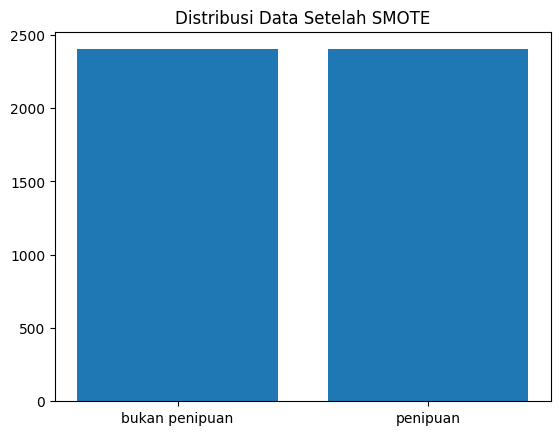

In [ ]:
import matplotlib.pyplot as plt
plt.bar(Counter(y_smote).keys(), Counter(y_smote).values())
plt.title('Distribusi Data Setelah SMOTE')
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# Memuat dataset hasil SMOTE
smote_data = pd.read_csv('cleaned_SMOTE_Ling_new.csv')

# Pastikan kolom 'text' bertipe data string
smote_data['text'] = smote_data['text'].astype(str)

# Pisahkan fitur dan label
X = smote_data.drop('label', axis=1)  # Semua kolom kecuali label
y = smote_data['label']  # Kolom label

# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Membuat TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),  # Uji dengan unigram dan bigram
    max_df=0.9,          # Hilangkan kata terlalu umum
    min_df=1             # Hilangkan kata yang jarang muncul
)
X_tfidf = vectorizer.fit_transform(X)
X_train_tfidf = vectorizer.fit_transform(X_train['text'].astype(str))  # Transformasi teks untuk data latih
X_test_tfidf = vectorizer.transform(X_test['text'].astype(str))  # Transformasi teks untuk data uji

# Membuat Model Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Evaluasi Model
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


                precision    recall  f1-score   support

bukan penipuan       0.00      0.00      0.00       502
      penipuan       0.48      1.00      0.65       459

      accuracy                           0.48       961
     macro avg       0.24      0.50      0.32       961
  weighted avg       0.23      0.48      0.31       961



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
feature_names = vectorizer.get_feature_names_out()
print("Top 10 Fitur Penting:", feature_names[:10])


Top 10 Fitur Penting: ['0012326835492456' '0020390952371889' '003568000065605'
 '0038385269482655' '0042781672096505' '005189188802941'
 '0054885661554487' '0055364414139772' '0056259610625607'
 '0066688171732551']


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Prediksi dan evaluasi ulang
y_pred = model.predict(X_test_tfidf)

# Lihat confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Laporan klasifikasi
print("Classification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[  0 502]
 [  0 459]]
Classification Report:
                 precision    recall  f1-score   support

bukan penipuan       0.00      0.00      0.00       502
      penipuan       0.48      1.00      0.65       459

      accuracy                           0.48       961
     macro avg       0.24      0.50      0.32       961
  weighted avg       0.23      0.48      0.31       961



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from collections import Counter
print("Distribusi label setelah SMOTE:", Counter(y_smote))

Distribusi label setelah SMOTE: Counter({'bukan penipuan': 2401, 'penipuan': 2401})


In [ ]:
# Prediksi menggunakan data uji
y_pred = model.predict(X_test)

# Evaluasi model menggunakan metrik
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


NameError: name 'X_test' is not defined

In [ ]:
# Simpan vectorizer dan model untuk digunakan nanti
joblib.dump(vectorizer, '/content/mydrive/MyDrive/tfidf_vectorizer.pkl')
joblib.dump(model, '/content/mydrive/MyDrive/naive_bayes_model.pkl')


In [ ]:
from google.colab import drive
drive.flush_and_unmount()


In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
# Memuat model dan vectorizer yang sudah disimpan
loaded_vectorizer = joblib.load('/content/mydrive/MyDrive/tfidf_vectorizer.pkl')
loaded_model = joblib.load('/content/mydrive/MyDrive/naive_bayes_model.pkl')

# Misalnya, prediksi untuk teks baru
new_text = ["This is a phishing email!"]
new_tfidf = loaded_vectorizer.transform(new_text)
prediction = loaded_model.predict(new_tfidf)

print("Prediksi label:", prediction)


Prediksi label: ['penipuan']


In [ ]:
from sklearn.metrics import classification_report

# Prediksi pada data uji
y_pred = model.predict(X_test)

# Menampilkan laporan klasifikasi untuk evaluasi
print(classification_report(y_test, y_pred))


NameError: name 'X_test' is not defined

In [ ]:
# Preprocessing yang sama seperti yang dilakukan pada data pelatihan
new_text_processed = [text.lower() for text in new_text]  # Jika Anda melakukan lowercasing
new_tfidf = loaded_vectorizer.transform(new_text_processed)
prediction = loaded_model.predict(new_tfidf)

print("Prediksi label:", prediction)

# **UJI COBA TEKS BARU**

In [ ]:
import joblib

# Memuat model dan vectorizer yang sudah disimpan
loaded_vectorizer = joblib.load('/content/mydrive/MyDrive/tfidf_vectorizer.pkl')
loaded_model = joblib.load('/content/mydrive/MyDrive/naive_bayes_model.pkl')

In [ ]:
# Teks baru yang ingin diuji
new_text = ["This is a phishing email, click here to claim your prize!"]

# Transformasi teks baru menjadi fitur numerik dengan vectorizer yang sudah dilatih
new_tfidf = loaded_vectorizer.transform(new_text)


In [ ]:
# Prediksi menggunakan model yang sudah dilatih
prediction = loaded_model.predict(new_tfidf)

# Menampilkan hasil prediksi
print("Prediksi label:", prediction)


Prediksi label: ['penipuan']


In [ ]:
# Misalnya, teks lainnya
new_text2 = ["This is a legitimate job offer. Apply now!"]

# Transformasi dan prediksi
new_tfidf2 = loaded_vectorizer.transform(new_text2)
prediction2 = loaded_model.predict(new_tfidf2)
print("Prediksi label:", prediction2)


Prediksi label: ['penipuan']


# **EVALUASI MODEL**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Cross-validation dengan scoring yang lebih lengkap
scoring = ['accuracy', 'precision', 'recall', 'f1']
results = {}

# Lakukan cross-validation untuk masing-masing metrik
# PERUBAHAN: Gunakan X_tfidf, bukan X
for score in scoring:
    scores = cross_val_score(loaded_model, X_tfidf, y, cv=5, scoring=score)
    results[score] = scores.mean()

print("Evaluation Results from Cross-Validation:")
for metric, result in results.items():
    print(f"{metric}: {result:.4f}")

NameError: name 'X_tfidf' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasi confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bukan Penipuan', 'Penipuan'], yticklabels=['Bukan Penipuan', 'Penipuan'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


NameError: name 'y_test' is not defined

In [ ]:
# Periksa kesalahan prediksi (false positives dan false negatives)
false_positive = (y_pred == 'penipuan') & (y_test == 'bukan penipuan')
false_negative = (y_pred == 'bukan penipuan') & (y_test == 'penipuan')

print(f"False Positives: {sum(false_positive)}")
print(f"False Negatives: {sum(false_negative)}")


NameError: name 'y_pred' is not defined